## Pedestrian Safety Industry Project






# Setup

In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
%cd yolov5
%pip install -r requirements.txt
!pip install wandb
!pip install roboflow

# Train

In [ ]:
cd /content

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="EmfmzC66fkPtmN5sGdOv")
project = rf.workspace().project("crosswalks-3hzsd")
dataset = project.version(10).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Crosswalks-7 in yolov5pytorch:: 100%|██████████| 1002/1002 [00:01<00:00, 656.92it/s]


In [ ]:
!python yolov5/train.py --img 640 --epochs 50 --batch 32 --data Crosswalks-10/data.yaml --weights yolov5/yolov5s.pt --adam

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
train: weights=yolov5/yolov5s.pt, cfg=, data=Crosswalks-7/data.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=True, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=lat

# Description of Model


1.   Yolov5 uses a Binary Cross-entropy with Logits Loss function which is calculated to measure the bounding box regression score, objectness score ( which measures how well the model is finding the location and class of an object), and class probability score (which rewards high probabilities for correct classifications and punishes high probabilities for incorrect classifications)
2.   The model consists of 213 layers beginning with a several convolutionary layers, then a dense bunch of layers using Leaky RELU as the activation function, then at the output layer it uses Sigmoid.
3.   The Hyper-parameters are Learning Rate: .01, Optimizer: Adam-Optimizer, Batch Size: 32.



# Experimentation


1.  We set up our experiment by taking photos of crosswalks in Davidson as well as around our local areas in order to train a variety of crosswalk styles into the model. We then used a website named Roboflow to annotate these pictures with bounding boxes and classifications. 
2.  The data is split with 70% Training, 20% Validation, 10% Testing
3.  We experimented with using SGD as the optimization function in the model instead of Adam, and we also tried using 16 instead of 32 batch size, but we found that Adam with 32 batch brought the best results.
4.  The libraries used are: Yolov5, Roboflow, Wandb, and CV2

# Motivation for this Method

We chose to use the Yolov5 model based on the reccomendation of Phillipe Loher who is our Advisor for this industry project. He reccomended this library because it is pretrained to detect a wide range of objects and can easily be extended to detect other things. We expanded the model to be able to detect crosswalks.

https://github.com/ultralytics/yolov5

# Inference

In [ ]:
!python yolov5/detect.py --img 640 --conf .25 --weights yolov5/runs/train/exp/weights/best.pt --source Crosswalks-7/test/images

detect: weights=['yolov5/runs/train/exp/weights/best.pt'], source=Crosswalks-7/test/images, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-61-g8535053 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/49 /content/Crosswalks-7/test/images/ezgif-frame-001-4-_jpg.rf.59bb8b096337da0afadeac360497afd4.jpg: 640x640 1 Crosswalk, Done. (0.034s)
image 2/49 /content/Crosswalks-7/test/images/ezgif-frame-005-4-_jpg.rf.bc68a1e1535920aa5e797176019b2109.jpg: 640x640 1 Crosswalk, 1 car, Done. (0.033s)
image 3/49 /content/Crosswalks-7/test/images/ezgif-frame-007_jpg.rf.2c050f31f673c06

# Pedestrian-in-Crosswalk Detection

In [ ]:
%pylab inline
import cv2
import os
from yolov5 import detect
import torch
def ped_in_crosswalk(vid):
  #path = path to model
  model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Ped_Safety_Models/training_set_v10.pt', force_reload=True)
  vidcap = cv2.VideoCapture(vid)
  success, frame = vidcap.read()
  count = 0
  if not os.path.isdir('frames'):
    os.mkdir('frames')
  out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc('m','p','4','v'), 15, (frame.shape[1], frame.shape[0]))
  boxes = []
  while success:
    cv2.imwrite("frames/frame%d.jpg" % count, frame)
    result = model('frames/frame%d.jpg' % count)
    out_pic = result.render()[0]
    preds = result.pred
    cwalk = ''
    ped = False
    for i, p in enumerate(preds[0]):
      if p[5] == 0:
        if cwalk != '':
          if cwalk[4] < p[4]:
            cwalk =  p
        else:
          cwalk = p
    print(cwalk)
    if cwalk != '':
      for i, p in enumerate(preds[0]):
        if p[5] == 2:
          midx = (p[0].item() + p[2].item()) / 2
          miny = p[3].item()
          print(midx)
          print(miny)
          if (midx >= cwalk[0].item() and midx <= cwalk[2].item()) and (miny >= cwalk[1].item() and miny <= cwalk[3].item()):
            ped = True
    if ped:
      out_copy = out_pic.copy()

      # font
      font = cv2.FONT_HERSHEY_TRIPLEX
        
      # org
      org = (int(frame.shape[1] * .20), int(frame.shape[0] * .125))
        
      # fontScale
      fontScale = 3
        
      # Blue color in BGR
      color = (0, 0, 255)
        
      # Line thickness of 2 px
      thickness = 4
        
      # Using cv2.putText() method
      image = cv2.putText(out_copy, 'Pedestrian in Crosswalk', org, font, 
                        fontScale, color, thickness, cv2.LINE_AA)
      out.write(image)
    else:
      out.write(out_pic)
    print(ped)
    success, frame = vidcap.read()
    count += 1
  out.release()


    

In [ ]:
#path to video to be analyzed
#output saved to output.mp4
ped_in_crosswalk('/content/drive/MyDrive/20211128_150720_SparkVideo.mp4')

Populating the interactive namespace from numpy and matplotlib


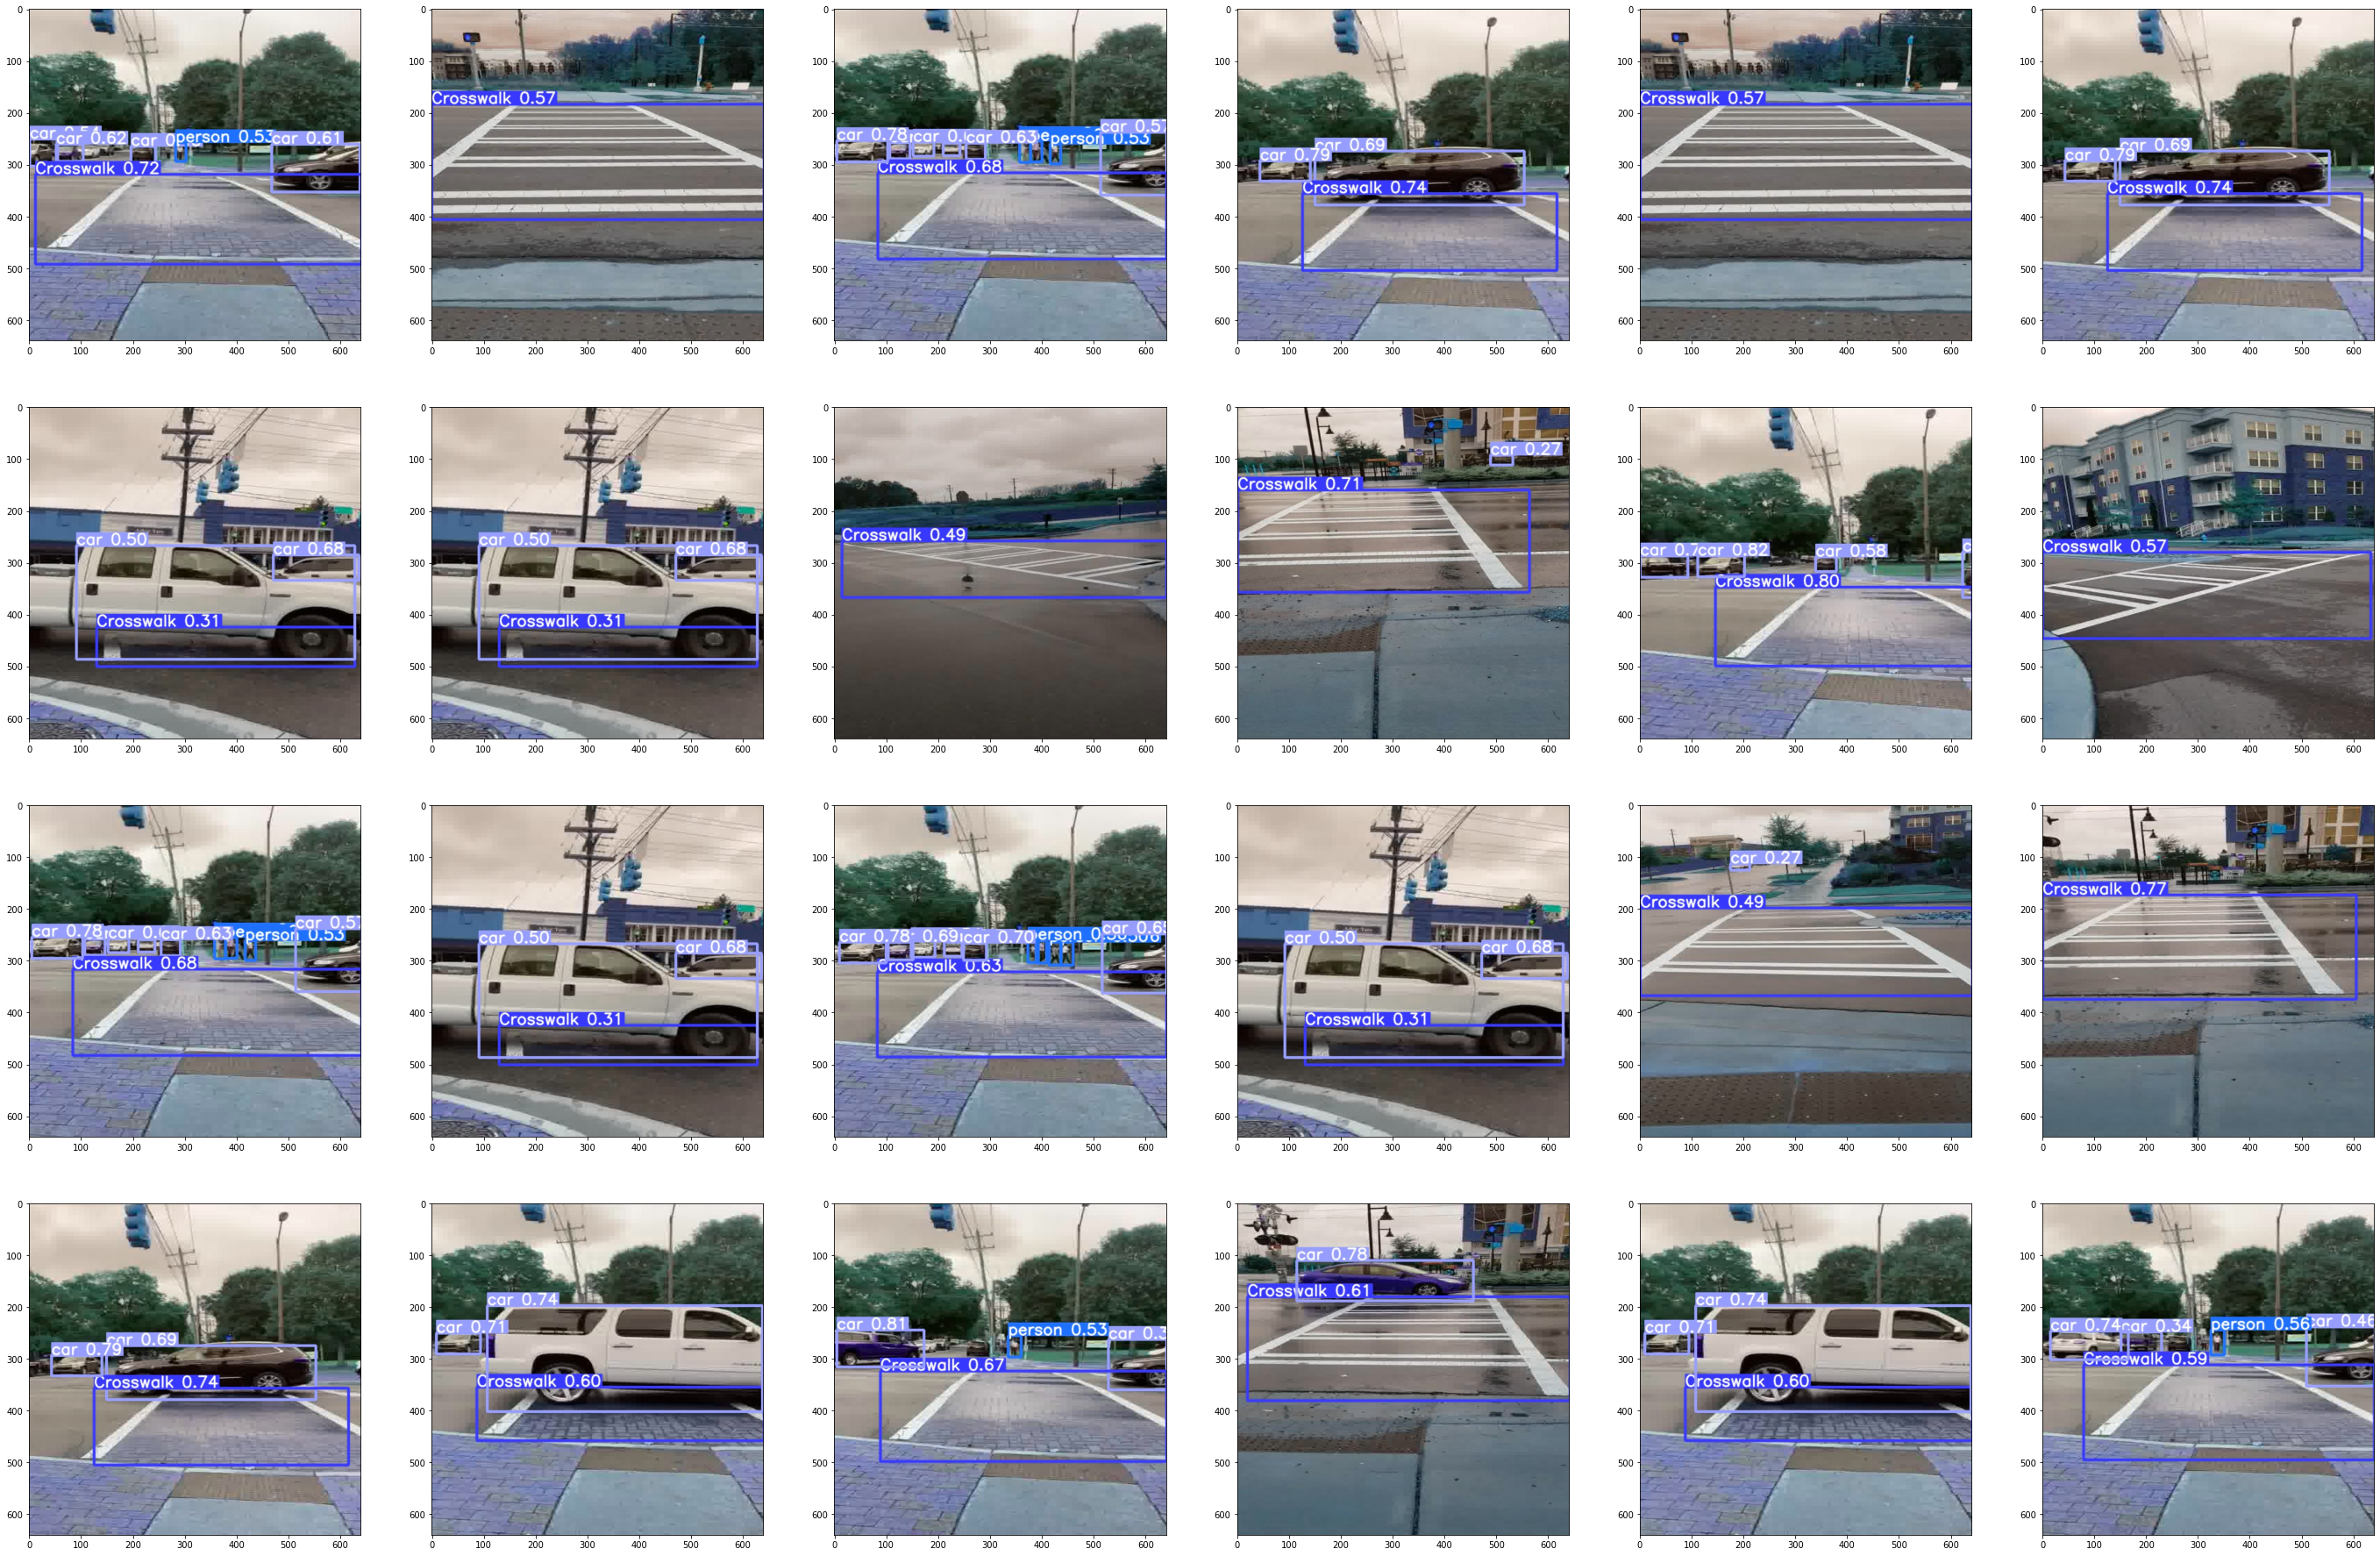

In [ ]:
%pylab inline
import cv2
import os
import random
res_pics = os.listdir('yolov5/runs/detect/exp')
rows=4
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(48,32))
N = 24
random_pics = random.choices(res_pics, k=N)
m = 0
for i, image in enumerate(random_pics):
  row = i // cols
  col =  i % cols
  cur_pic = cv2.imread('yolov5/runs/detect/exp/' + image)
  axs[row, col].imshow(cur_pic)

# Results

* Precision: .85
* Recall: .82
* Mean Average Precision (when confidence > .5): .88

Graphs detailing loss descent for Bounding Box, Objectness, and Classification Probability loss, for both the training and validation set, as well as the improvement of precision, recall, and Mean Average Precision after each iteration. 

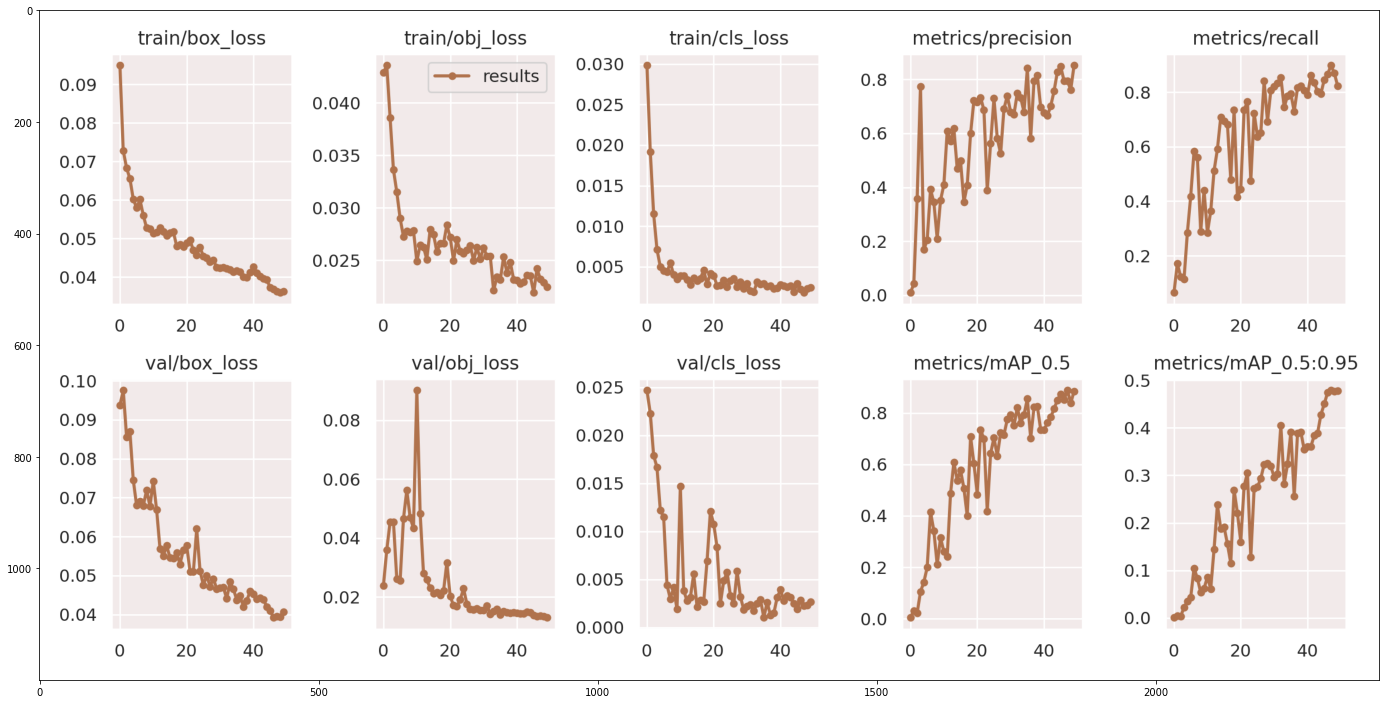

In [ ]:
res = cv2.imread('yolov5/runs/train/exp/results.png')
fig = figure(0, (24, 28))
imshow(res);